# Letter Classification

## References
- [1] https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
- [2] https://data-flair.training/blogs/handwritten-character-recognition-neural-network/
- [3] https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- [4] https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb

(07.04.2022 00:30)

## Downloading the neccessary packages

In [ ]:
pip install pandas numpy tensorflow keras sklearn matplotlib

## Data Preprocessing
- Input: coloured images in a flattened form (25x25x3 -> 72220).
- The data is already normalized, the values are between 0 and 1.
- I choose to reshape X because I found that CNNs can classify letters quite well.
- Working with pictures is also more understandable for humans.

In [17]:
import pandas as pd
import numpy as np

In [18]:
X = pd.read_csv("X_train.csv", index_col=0).values
y = pd.read_csv("y_train.csv", index_col=0).values

In [19]:
X = X.reshape(77220, 25, 25, 3)

In [20]:
shuffled = np.arange(len(X))
np.random.shuffle(shuffled)
X = X[shuffled]
y = y[shuffled]

In [21]:
n_train = int(0.8*len(X))
n_train

61776

In [22]:
x_train = X[:n_train]
x_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

In [23]:
from tensorflow.keras.utils import to_categorical # NNs needs the labels in this form
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [24]:
n_classes=26 # letters in the alphabet

## Model Definition
My model is based on references [1] and [2]. I tried to understand the decisions in these references and change the model in some parts. These original models were already very accurate, so most of my changes at the beginning only decreased the accuracy.

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, Flatten, MaxPool2D
from keras.optimizers import SGD, Adam
import tensorflow as tf

In [26]:
x_train.shape

(61776, 25, 25, 3)

### Input layer

In [27]:
model = Sequential()

### Hidden layers
I found that CNNs usually have 3 types of layers[2][3][4]. There are some convolutional parts right after the input layer, to "sum" certain parts of the picture together. I think it's like analysing specific parts of a letter. Compared to [1] I changed the kernel_size to 5 ([3] uses it too), it seems to work with the traning set better. I didn't replace ReLU because it's widely used to increase non-linearity[3].

In [28]:
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(25,25,3),
                 data_format="channels_last"))

After the convolutional layer, people use a pooling layer. It's useful to find dominant features[3] and prevent overfitting[4]. I changed both the pool_size and the strides and this setting seemed to work well. I think bigger numbers can't explain the patterns that better, and it also decreases the size more, which limits the number of layers. With 2x2 pooling, maximum pooling makes more sense than average pooling, to highlight dominant parts of the picture.

In [29]:
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

I found a good balance by using two convolutional layers. The model with one layer could be improved and 3 layers seemed not to give much benefit. Here I used padding, to not to make the data too small and it could increase accuracy a bit, but maybe it was random.

In [30]:
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

At last, CNN uses "regular" NN layers with nodes. For that we need to flatten the data from the pooling layer. Reference [2] uses another layer with 128 nodes after the 64 one. My intuition was that at the end the number should just decrease, and the layer before the output layer should be somewhat bigger than the output layer. I got better accuracy with 64 nodes than 128 nodes.

In [31]:
model.add(Flatten())
model.add(Dense(64,activation ="relu"))

### Output layer
For multiclass classification softmax seems to be a good algorithm.[1][4]

In [33]:
model.add(Dense(26,activation ="softmax"))

## Model Training
There wasn't really much difference between Adam and SGD so I choose Adam because it might prevent overfitting and it seemed to be a bit faster.

In [35]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 21, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [36]:
h = model.fit(x_train, y_train_cat, epochs=5, validation_split=0.2)

Epoch 1/5
1545/1545 [==============================] - 59s 36ms/step - loss: 0.5894 - accuracy: 0.8354 - val_loss: 0.1985 - val_accuracy: 0.9459
Epoch 2/5
1545/1545 [==============================] - 54s 35ms/step - loss: 0.1604 - accuracy: 0.9529 - val_loss: 0.1116 - val_accuracy: 0.9698
Epoch 3/5
1545/1545 [==============================] - 57s 37ms/step - loss: 0.1013 - accuracy: 0.9688 - val_loss: 0.1146 - val_accuracy: 0.9646
Epoch 4/5
1545/1545 [==============================] - 58s 38ms/step - loss: 0.0766 - accuracy: 0.9761 - val_loss: 0.0895 - val_accuracy: 0.9730
Epoch 5/5
1545/1545 [==============================] - 58s 37ms/step - loss: 0.0605 - accuracy: 0.9808 - val_loss: 0.1039 - val_accuracy: 0.9688


## Determining accuracy

In [37]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model.predict(x_test), axis=1)
accuracy_score(y_test, y_pred)

483/483 [==============================] - 6s 11ms/step


0.9677544677544677

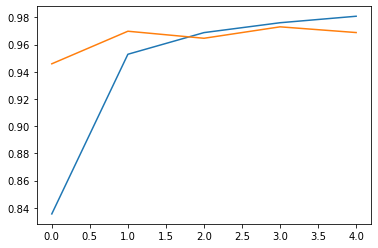

In [40]:
import matplotlib.pyplot as plt
plt.plot(h.history["accuracy"])
plt.plot(h.history["val_accuracy"])

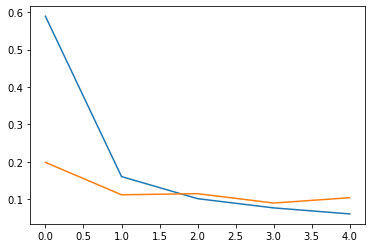

In [41]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])